In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from PIL import Image
import os
from tqdm import tqdm
from IPython.display import clear_output
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np 
import matplotlib.patches as mpatches
from collections import Counter
import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import sys
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import Dataset

In [2]:
!pip install xmltodict

In [5]:
import xmltodict

In [7]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [8]:
path_annotations="/kaggle/input/face-mask-detection/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


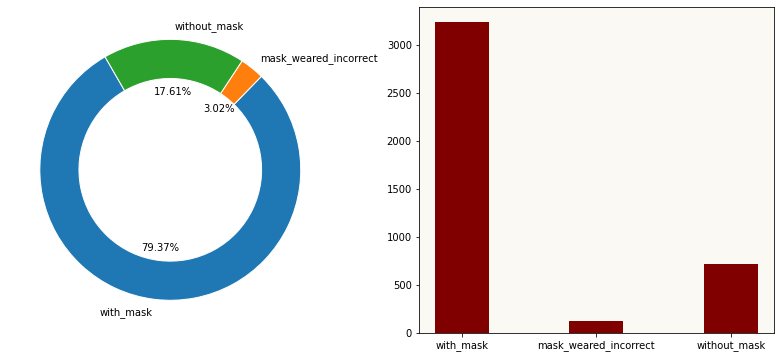

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

In [10]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.9.1


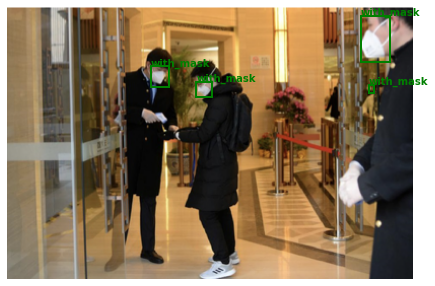

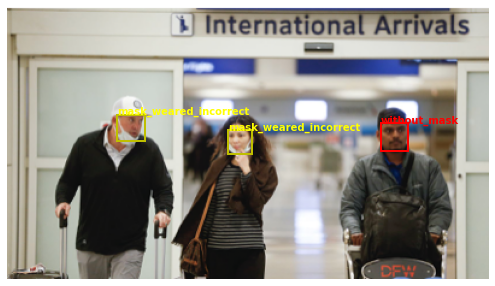

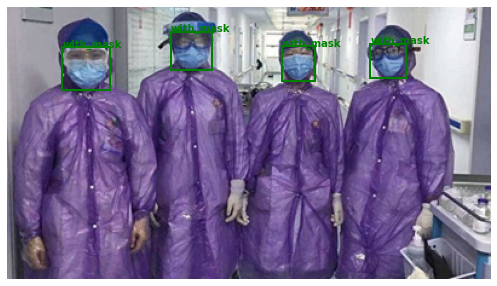

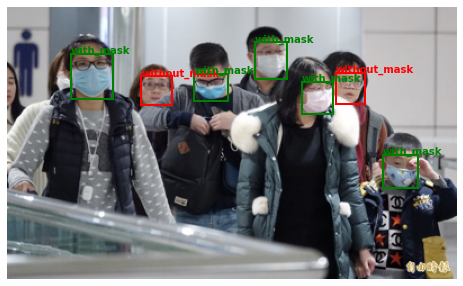

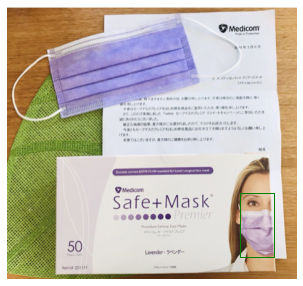

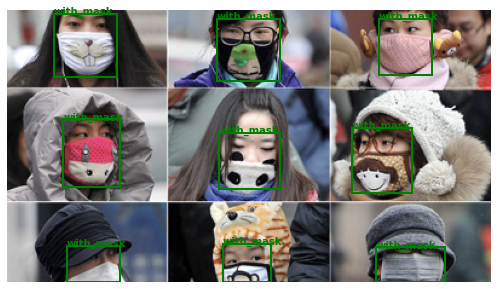

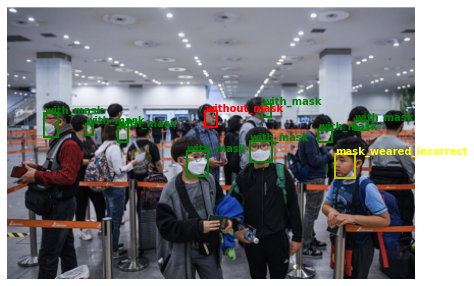

In [11]:
path_image="/kaggle/input/face-mask-detection/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

In [ ]:


def get_model(n_classes=4):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
    return model


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')
model = get_model()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)
model.to(device)

Device: cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [15]:
path_image="/kaggle/input/face-mask-detection/images/"
fun_images = img_names.copy()
rows = []
for i in range(1, len(fun_images)):
    with open(path_annotations+fun_images[i][:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
        temp=doc["annotation"]["object"]
        for item in temp:    
            if (not isinstance(item, str)):
                rows.append([fun_images[i], item['name'], int(item['bndbox']['xmin']), int(item['bndbox']['xmax']), int(item['bndbox']['ymin']), int(item['bndbox']['ymax'])])
        #annotations.append(rows)
annotations_df = pd.DataFrame(np.array(rows), columns =['image', 'label', 'x_min', 'x_max', 'y_min', 'y_max'])  
print(annotations_df)

                    image                  label x_min x_max y_min y_max
0     maksssksksss848.png              with_mask   141   159    58    78
1     maksssksksss848.png              with_mask   186   201    73    88
2     maksssksksss848.png              with_mask   348   377     8    54
3     maksssksksss848.png              with_mask   356   361    76    84
4     maksssksksss145.png  mask_weared_incorrect    91   114    89   111
...                   ...                    ...   ...   ...   ...   ...
3738  maksssksksss359.png              with_mask   345   362    33    53
3739  maksssksksss359.png              with_mask   368   385    38    59
3740  maksssksksss359.png              with_mask   332   341    42    54
3741  maksssksksss736.png              with_mask   114   142    40    76
3742  maksssksksss736.png              with_mask   183   221    57    99

[3743 rows x 6 columns]


In [16]:
images = os.listdir('../input/face-mask-detection/images')
unique_images = annotations_df['image'].unique()
#images = np.array(images).isin(unique_images)
print(len(annotations_df))
#annotations_df = annotations_df[annotations_df['image'].isin([images])]
print(len(annotations_df))

3743
3743


USED ONLY IN CASE OF MASKDATASET FOR AUGMENTATIONS IN CLASS MASK_WEARED_INCORRECT

In [17]:


class MaskDataset(Dataset):
    
    def __init__(self, root_path, annotations_df, transform=None, is_train=False):
        self.root_path = root_path
        self.annotations_df = annotations_df
        self.images_list = annotations_df['image'].unique()
        self.labels_dict = {'without_mask': 1, 'with_mask': 2, 'mask_weared_incorrect': 3}
        self.transform = transform
        self.is_train = is_train
    
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, 'images', self.images_list[idx])
        img = np.array(Image.open(img_path).convert('RGB'))
        labels = self.annotations_df[self.annotations_df['image'] == self.images_list[idx]]['label'].values

        if self.is_train and 'mask_weared_incorrect' in labels and self.transform:
            # Apply a random horizontal flip with 50% probability if "mask_weared_incorrect" is in labels and in the training set
            augmented = self.transform(image=img)
            img = augmented['image']
        elif self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        
        img_data_df = self.annotations_df[self.annotations_df['image'] == self.images_list[idx]]
        n_bboxes = img_data_df.shape[0]
        bboxes = []
        labels = []
        
        for i in range(n_bboxes):
            img_data = img_data_df.iloc[i]
            x_min = int(img_data.x_min)
            x_max = int(img_data.x_max)
            y_min = int(img_data.y_min)
            y_max = int(img_data.y_max)
            bboxes.append([x_min, y_min, x_max, y_max])
            label = self.labels_dict[img_data.label]
            labels.append(label)

        img = torch.as_tensor(img / 255.0, dtype=torch.float32)  # Normalize to [0, 1]
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        target['image_id'] = image_id
        
        return img, target


USED ONLY FOR SPLITTING IN CASE OF AUGMENTATIONS IN CLASS MASK_WEARED_INCORRECT

In [49]:

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  #
    A.Resize(226, 226),  # Resize the image
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use standard mean and std for ImageNet
    ToTensorV2(),  # Convert the image to PyTorch tensor
])



train_dataset = MaskDataset('../input/face-mask-detection/', annotations_df, transform=train_transform, is_train=True)

test_dataset = MaskDataset('../input/face-mask-detection/', annotations_df, transform=val_test_transform)


batch_size = 16


N_TEST = 80


idxs = torch.randperm(len(train_dataset)).tolist()

# Split the indices into train, validation, and test sets
idxs_train = idxs[:-N_TEST - N_VALIDATION]
idxs_validation = idxs[-N_TEST - N_VALIDATION:-N_TEST]
idxs_test = idxs[-N_TEST:]

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(torch.utils.data.Subset(train_dataset, idxs_train), batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(torch.utils.data.Subset(test_dataset, idxs_test), batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [24]:
#USED ONLY IN CASE OF  AUGMENTATIONS IN ALL TRAIN DATA
class MaskDataset(Dataset):
    
    def __init__(self, root_path, annotations_df, transform=None):
        self.root_path = root_path
        self.annotations_df = annotations_df
        self.images_list = annotations_df['image'].unique()
        self.labels_dict = {'without_mask': 1, 'with_mask': 2, 'mask_weared_incorrect': 3}
        self.transform = transform
    
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, 'images', self.images_list[idx])
        img = np.array(Image.open(img_path).convert('RGB'))
        
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        
        img_data_df = self.annotations_df[self.annotations_df['image'] == self.images_list[idx]]
        n_bboxes = img_data_df.shape[0]
        bboxes = []
        labels = []
        
        for i in range(n_bboxes):
            img_data = img_data_df.iloc[i]
            x_min = int(img_data.x_min)
            x_max = int(img_data.x_max)
            y_min = int(img_data.y_min)
            y_max = int(img_data.y_max)
            bboxes.append([x_min, y_min, x_max, y_max])
            label = self.labels_dict[img_data.label]
            labels.append(label)

        img = torch.as_tensor(img / 255.0, dtype=torch.float32)  # Normalize to [0, 1]
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        target['image_id'] = image_id
        
        return img, target


**MASKDATASET WITHOUT AUGMENTATIONS**

In [21]:
class MaskDataset(object):
    
    def __init__(self, root_path, transform=None):
        self.root_path = root_path        
        self.images_df = annotations_df
        self.images_list = annotations_df['image'].unique()
        self.labels_dict = {'without_mask': 1, 'with_mask': 2, 'mask_weared_incorrect': 3}
        self.transform = transform
    
    def get(self, idx):
        img_path = os.path.join(self.root_path, 'images', self.images_list[idx])
        img = np.array(Image.open(img_path).convert('RGB')) / 255
        img = np.moveaxis(img, 2, 0) # to [C, H, W]
        
        if self.transform:
            img = np.moveaxis(img, 0, -1)
            img = self.transform(image=img)['image']
        
        # Collect data about boxes and helmet labels from `image_labels.csv`
        img_data_df = self.images_df[self.images_df['image'] == self.images_list[idx]]     
        n_bboxes = img_data_df.shape[0]
        bboxes = []
        labels = []
        for i in range(n_bboxes):
            img_data = img_data_df.iloc[i]
            x_min = int(img_data.x_min)
            x_max = int(img_data.x_max)
            y_min = int(img_data.y_min)
            y_max = int(img_data.y_max)
            bboxes.append([x_min, y_min, x_max, y_max])
            label = self.labels_dict[img_data.label]                
            labels.append(label)

        # Convert data to tensors
        img = torch.as_tensor(img, dtype=torch.float32)    
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        target['image_id'] = image_id
        return img, target
            
    def __getitem__(self, idx):
        return self.get(idx)
        
    
    
    def __len__(self):
        return len(self.images_list)

In [26]:
#USED ONLY IN CASE OF  AUGMENTATIONS IN ALL TRAIN DATA


train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.Resize(226, 226),  
    A.Normalize(),  
    ToTensorV2(),  
])



train_dataset = MaskDataset('../input/face-mask-detection/', transform=train_transform, annotations_df=annotations_df)

N_TEST = 80

batch_size = 10

idxs = torch.randperm(len(train_dataset)).tolist()

idxs_train = idxs[:-N_TEST ]

idxs_test = idxs[-N_TEST:]

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(torch.utils.data.Subset(train_dataset, idxs_train), batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

test_dataset = MaskDataset('../input/face-mask-detection/', transform=val_test_transform, annotations_df=annotations_df)
test_dataloader = DataLoader(torch.utils.data.Subset(test_dataset, idxs_test), batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

**SPLITTING DATA WITHOUT AGUMENTATIONS**

In [24]:
Batch_size_test = 6
N_TEST = 80

dataset = MaskDataset('../input/face-mask-detection/')


# train and test split
idxs = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, idxs[:-N_TEST])
dataset_test = torch.utils.data.Subset(dataset, idxs[-N_TEST:])
                      
train_dataloader = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=6,
                                               shuffle=True,
                                               num_workers=2,
                                               collate_fn=collate_fn)
                      
test_dataloader = torch.utils.data.DataLoader(dataset_test,
                                               batch_size=Batch_size_test,
                                               shuffle=True,
                                               num_workers=2,
                                               collate_fn=collate_fn)

In [1]:
def forward_train(model, data, device):
    imgs, targets = data
    imgs = [image.to(device) for image in imgs]
    targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
    loss_dict = model(imgs, targets) 
    losses = sum(loss for loss in loss_dict.values())
    #losses += loss_dict['loss_classifier']*2
    return losses, loss_dict

2

In [26]:
def evaluate(model, data, device):
    #model.eval()
    final_outputs = []
    with torch.no_grad():        
        imgs, targets = data
        imgs = [image.to(device) for image in imgs]
        targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
        loss_dict = model(imgs, targets) 
        losses = sum(loss for loss in loss_dict.values())
    return losses, loss_dict

In [27]:
import gc

gc.collect()

torch.cuda.empty_cache()

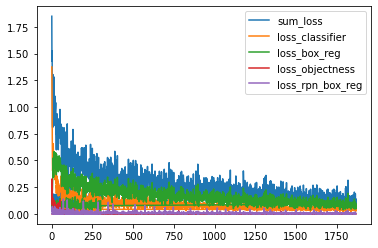

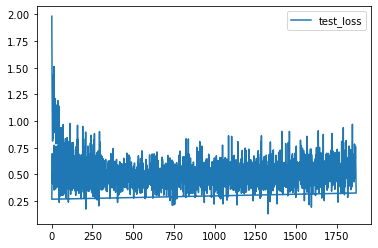

In [ ]:
N_ITERS = 150
epochs = 2

progress_bar = tqdm(range(int(len(annotations_df)/2)))
tr_it = iter(train_dataloader)
test_it = iter(test_dataloader)
loss_log = []
test_loss_log = []
iterations = []
losses_for_tim = []
loss_classifier = []
loss_box_reg = []
loss_objectness = []
loss_rpn_box_reg = []
for e in range(epochs): 
    print(f"--- epoch: {e} ---")
    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        model.train()
        torch.set_grad_enabled(True)
        losses, loss_dict = forward_train(model, data, device)
        losses_for_tim.append(loss_dict)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_log.append(losses.item())
        iterations.append(i)

        loss_classifier.append(loss_dict['loss_classifier'].detach().cpu().numpy())
        loss_box_reg.append(loss_dict['loss_box_reg'].detach().cpu().numpy())
        loss_objectness.append(loss_dict['loss_objectness'].detach().cpu().numpy())
        loss_rpn_box_reg.append(loss_dict['loss_rpn_box_reg'].detach().cpu().numpy())
        try:
            data = next(test_it)
        except StopIteration:
            test_it = iter(test_dataloader)
            data = next(test_it)
        test_loss, test_loss_dict = evaluate(model, data, device)
        test_loss_log.append(test_loss)
        
        if i % 100 == 0:     
            progress_bar.set_description(f'batch loss: {losses.item()}, average loss: {np.mean(loss_log)}.')     
            clear_output(True)
            plt.plot(iterations, loss_log, label="sum_loss")
            plt.plot(iterations, loss_classifier, label="loss_classifier")
            plt.plot(iterations, loss_box_reg, label="loss_box_reg")
            plt.plot(iterations, loss_objectness, label="loss_objectness")
            plt.plot(iterations, loss_rpn_box_reg, label="loss_rpn_box_reg")
            plt.legend(loc="upper right")
            plt.show()   
            
            plt.plot(iterations, test_loss_log, label="test_loss")
    
            #predictions, valid_targets = evaluate(test_dataloader, model, device=device)
            #roc_auc = metrics.roc_auc_score(valid_targets, predictions)
            plt.legend(loc="upper right")
            plt.show()


In [41]:

def evaluate(model, data, device):
    inputs, targets = data
    inputs = [input.to(device) for input in inputs]
    targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
    
    model.eval()
    
    with torch.no_grad():
        loss_dict = model(inputs, targets)
    
    return loss_dict


In [29]:
model.eval()
torch.set_grad_enabled(False)

test_it = iter(test_dataloader)

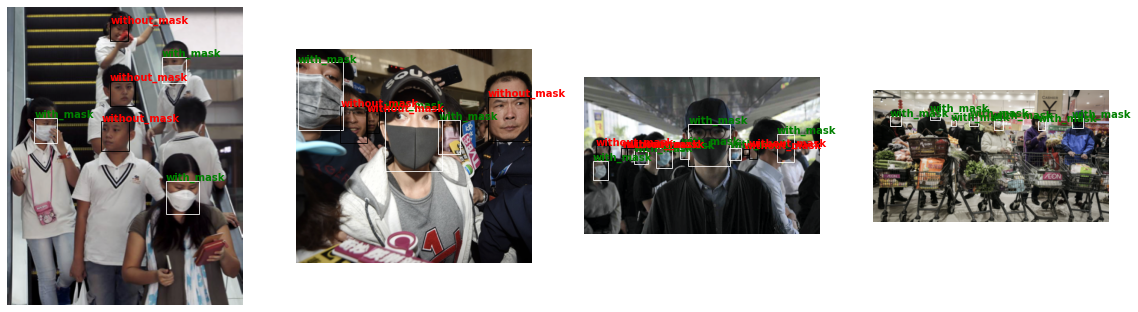

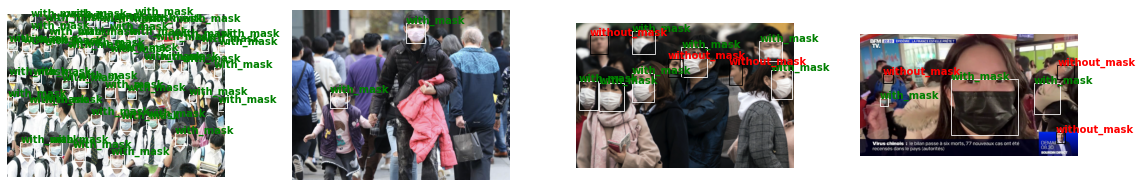

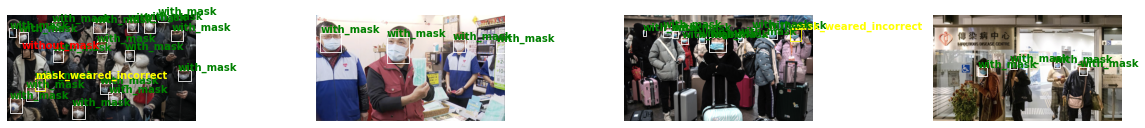

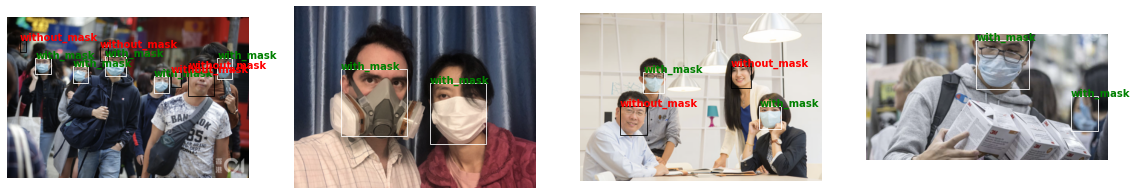

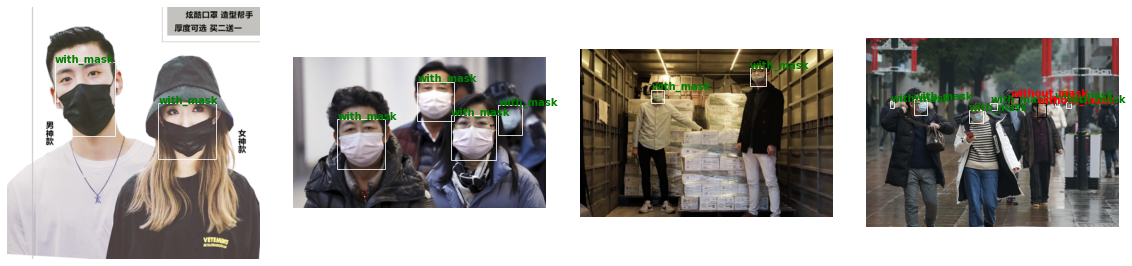

In [30]:
for i in range(5):
    test_img, test_gt  = next(test_it)
    test_img = [image.to(device) for image in test_img]
    predictions = model(test_img)

    plot_detected_bboxes(test_img, predictions,
                         n_to_plot=4,
                         score_threshold=0.5)